In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [7]:
df = load_pkl('./data/feat_engin/lgbm/data_15min_1hour_1day.pkl')

In [8]:
df.shape

(2340439, 1712)

In [10]:
df.head()

,time,close,volume,ticker,tmos_close,index_1hour,index_1day,result,delta_time,income_rate,...,tmos_close_1day_w10_min/tmos_close_1day_w10_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max,close_1day_w30_min/close_1day_w30_max,tmos_close_1day_w30_min/tmos_close_1day_w30_max,close_1day_w60_min/close_1day_w60_max,tmos_close_1day_w60_min/tmos_close_1day_w60_max,close_1day_w120_min/close_1day_w120_max,tmos_close_1day_w120_min/tmos_close_1day_w120_max
0,2022-05-04 10:00:00,31.520000,165423.0,AFLT,4.30,NaN,NaN,LOSE,0 days 00:15:00,0.994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-04 10:15:00,31.920000,99825.0,AFLT,4.32,NaN,NaN,LOSE,0 days 00:15:00,0.994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-04 10:30:00,32.400002,171391.0,AFLT,4.29,NaN,NaN,WIN,0 days 00:30:00,1.009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-04 10:45:00,32.099998,66741.0,AFLT,4.27,0.0,NaN,WIN,0 days 00:30:00,1.009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-04 11:00:00,31.940001,42552.0,AFLT,4.25,0.0,NaN,WIN,0 days 00:15:00,1.009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df['result'].value_counts(normalize=True)

result
LOSE    0.572551
WIN     0.327577
DNF     0.099872
Name: proportion, dtype: float64

In [12]:
df['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.994
0.01    0.994
0.10    0.994
0.20    0.994
0.30    0.994
0.40    0.994
0.50    0.994
0.60    0.999
0.70    1.009
0.80    1.009
0.90    1.009
0.99    1.009
1.00    1.009
Name: income_rate, dtype: float64

In [13]:
#распределение времени в часах
(df['delta_time']//pd.Timedelta('1 hour')).quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00       0.0
0.01       0.0
0.10       0.0
0.20       1.0
0.30       2.0
0.40       3.0
0.50       8.0
0.60      14.0
0.70      18.0
0.80      24.0
0.90      59.0
0.99      72.0
1.00    6736.0
Name: delta_time, dtype: float64

## CHANGE TARGET

In [16]:
def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: #short game
        mask_val_first = np.array(df['close'] > val_first)
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            if val_first < val_second:
                income_rate = res_price/start_price
            else: #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            if val_first < val_second:
                income_rate = res_price/start_price
            else:  #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })

    #макс выигрыш и потери
    if percent_first < percent_second:  
        df_result["income_rate"] = np.maximum(df_result["income_rate"], percent_first) #макс потери
        df_result["income_rate"] = np.minimum(df_result["income_rate"], percent_second) #макс выигрыш
    else:
        df_result["income_rate"] = np.maximum(df_result["income_rate"], 2-percent_first) #макс потери
        df_result["income_rate"] = np.minimum(df_result["income_rate"], 2-percent_second) #макс выигрыш
    
    df_result['income_rate'] -= 0.001
    
    return df_result    

In [17]:
inds = np.arange(df.shape[0])
inds.shape

(2340439,)

In [68]:
df_result = get_df_target(df[['time', 'close', 'ticker']], inds, percent_first=0.99, percent_second=1.03, points_to_wait=4*14*2)

100%|█████████████████████████████████████████████████████████████| 2340439/2340439 [25:26<00:00, 1533.19it/s]


In [74]:
dump_pkl(df_result, './data/feat_engin/lgbm/df_result_-1_+3_1day.pkl')

In [76]:
df_result = load_pkl('./data/feat_engin/lgbm/df_result_-1_+3_1day.pkl')
df_result

,ind,time,close,result,ticker,delta_time,income_rate,res_price,res_ind
0,0,2022-05-04 10:00:00,31.520000,LOSE,AFLT,0 days 04:15:00,0.989000,31.200001,17
1,1,2022-05-04 10:15:00,31.920000,LOSE,AFLT,0 days 01:00:00,0.989000,31.299999,5
2,2,2022-05-04 10:30:00,32.400002,LOSE,AFLT,0 days 00:30:00,0.989000,31.940001,4
3,3,2022-05-04 10:45:00,32.099998,LOSE,AFLT,0 days 00:30:00,0.989000,31.299999,5
4,4,2022-05-04 11:00:00,31.940001,LOSE,AFLT,0 days 00:15:00,0.989000,31.299999,5
...,...,...,...,...,...,...,...,...,...
2340434,2340434,2025-02-07 22:45:00,375.739990,DNF,BSPB,0 days 01:00:00,0.998894,375.700012,2340438
2340435,2340435,2025-02-07 23:00:00,375.709991,DNF,BSPB,0 days 00:45:00,0.998973,375.700012,2340438
2340436,2340436,2025-02-07 23:15:00,375.540009,DNF,BSPB,0 days 00:30:00,0.999426,375.700012,2340438
2340437,2340437,2025-02-07 23:30:00,375.700012,DNF,BSPB,0 days 00:15:00,0.999000,375.700012,2340438


In [79]:
df_result['result'].value_counts(normalize=True)


result
LOSE    0.570729
DNF     0.240621
WIN     0.188650
Name: proportion, dtype: float64

In [81]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.989000
0.01    0.989000
0.10    0.989000
0.20    0.989000
0.30    0.989000
0.40    0.989000
0.50    0.989000
0.60    0.995742
0.70    1.005768
0.80    1.021900
0.90    1.029000
0.99    1.029000
1.00    1.029000
Name: income_rate, dtype: float64

In [83]:
#распределение времени в часах
(df_result['delta_time']//pd.Timedelta('1 hour')).quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00       0.0
0.01       0.0
0.10       2.0
0.20       6.0
0.30      15.0
0.40      20.0
0.50      25.0
0.60      47.0
0.70      48.0
0.80      71.0
0.90      96.0
0.99     121.0
1.00    6768.0
Name: delta_time, dtype: float64

In [86]:
(df['close'].values == df_result['close'].values).all(), (df['time'].values == df_result['time'].values).all()

(True, True)

In [88]:
df_result.head()

,ind,time,close,result,ticker,delta_time,income_rate,res_price,res_ind
0,0,2022-05-04 10:00:00,31.520000,LOSE,AFLT,0 days 04:15:00,0.989,31.200001,17
1,1,2022-05-04 10:15:00,31.920000,LOSE,AFLT,0 days 01:00:00,0.989,31.299999,5
2,2,2022-05-04 10:30:00,32.400002,LOSE,AFLT,0 days 00:30:00,0.989,31.940001,4
3,3,2022-05-04 10:45:00,32.099998,LOSE,AFLT,0 days 00:30:00,0.989,31.299999,5
4,4,2022-05-04 11:00:00,31.940001,LOSE,AFLT,0 days 00:15:00,0.989,31.299999,5


In [91]:
df[['result', 'delta_time', 'income_rate', 'res_price', 'res_ind']] = df_result[['result', 'delta_time', 'income_rate', 'res_price', 'res_ind']]

In [94]:
#проверить данные

mask = df['time'] >= pd.Timestamp('2025-02-01')


i = 3676
cols = ['ticker', 'time', 'close', 'close_1hour', 'close_1day', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']
df.loc[mask, cols].iloc[i:i+10]

,ticker,time,close,close_1hour,close_1day,result,delta_time,income_rate,res_price,res_ind
491070,SGZH,2025-02-03 19:30:00,1.379,1.381,1.377,LOSE,1 days 02:15:00,0.989,1.364,491135
491071,SGZH,2025-02-03 19:45:00,1.378,1.378,1.377,LOSE,1 days 02:00:00,0.989,1.364,491135
491072,SGZH,2025-02-03 20:00:00,1.379,1.378,1.377,LOSE,1 days 01:45:00,0.989,1.364,491135
491073,SGZH,2025-02-03 20:15:00,1.379,1.378,1.377,LOSE,1 days 01:30:00,0.989,1.364,491135
491074,SGZH,2025-02-03 20:30:00,1.380,1.378,1.377,LOSE,1 days 01:15:00,0.989,1.364,491135
491075,SGZH,2025-02-03 20:45:00,1.379,1.379,1.377,LOSE,1 days 01:00:00,0.989,1.364,491135
491076,SGZH,2025-02-03 21:00:00,1.380,1.379,1.377,LOSE,1 days 00:45:00,0.989,1.364,491135
491077,SGZH,2025-02-03 21:15:00,1.379,1.379,1.377,LOSE,1 days 00:30:00,0.989,1.364,491135
491078,SGZH,2025-02-03 21:30:00,1.379,1.379,1.377,LOSE,1 days 00:15:00,0.989,1.364,491135
491079,SGZH,2025-02-03 21:45:00,1.380,1.380,1.377,LOSE,1 days 00:00:00,0.989,1.364,491135


In [96]:
i = 491081
df[cols].iloc[i:i+1]

,ticker,time,close,close_1hour,close_1day,result,delta_time,income_rate,res_price,res_ind
491081,SGZH,2025-02-03 22:15:00,1.389,1.38,1.377,LOSE,0 days 17:00:00,0.989,1.371,491109


### 1. train/valid/test/test2 split

In [101]:
df['target'] = (df['result'] == 'WIN').astype(int)

<Axes: xlabel='time'>

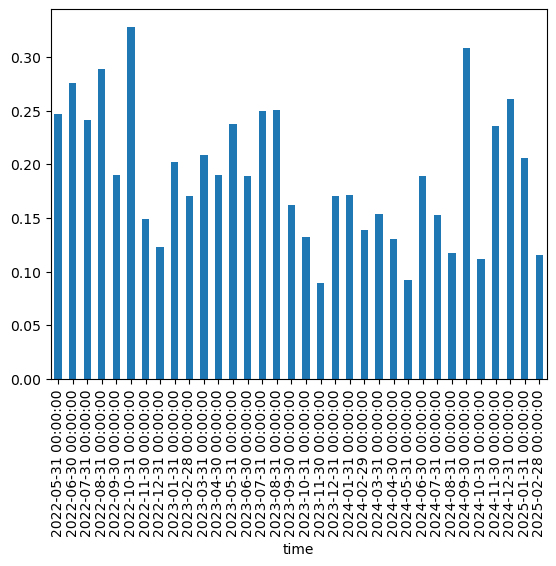

In [103]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

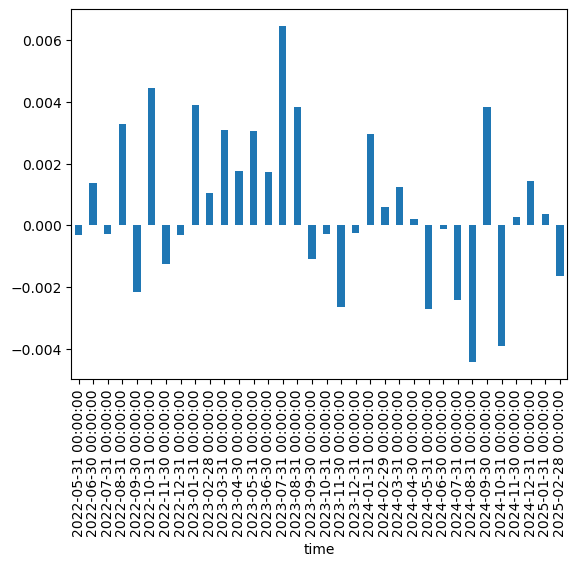

In [105]:
(df[['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [108]:
pd.set_option('display.max_rows', 150)
df[['ticker', 'target']].groupby('ticker').target.mean().sort_values()

ticker
IRAO     0.101125
MTSS     0.113505
PHOR     0.114045
GAZP     0.118163
SBERP    0.118210
HYDR     0.120039
LKOH     0.120271
SBER     0.125724
TATNP    0.131442
GMKN     0.131674
ROSN     0.139409
TRNFP    0.143644
TATN     0.143763
RTKM     0.144760
NVTK     0.147192
VSMO     0.151433
ALRS     0.151931
RUAL     0.155751
MOEX     0.160041
MAGN     0.160156
VTBR     0.163783
SGZH     0.164101
MGNT     0.168125
BELU     0.169130
SNGSP    0.171261
POSI     0.172856
SIBN     0.173207
SMLT     0.173453
NLMK     0.177615
CHMF     0.180045
PIKK     0.180558
ENPG     0.181154
PLZL     0.184355
UPRO     0.188261
SNGS     0.190166
AFLT     0.190451
AFKS     0.193217
FEES     0.200819
YDEX     0.204764
X5       0.208838
T        0.210326
MVID     0.216927
FLOT     0.217232
VKCO     0.224907
SPBE     0.226729
TRMK     0.226946
WUSH     0.231918
BSPB     0.236641
SELG     0.236704
RASP     0.239120
NMTP     0.239331
HEAD     0.244830
BANEP    0.244917
FESH     0.245703
ABIO     0.245802
UNA

In [110]:
df[['ticker', 'income_rate']].groupby('ticker').income_rate.mean().sort_values()

ticker
VSMO     0.997990
SGZH     0.999172
HYDR     0.999188
GAZP     0.999500
SMLT     0.999510
GMKN     0.999566
SPBE     0.999634
RUAL     0.999698
NVTK     0.999720
VTBR     0.999836
ENPG     0.999854
PHOR     0.999895
ABIO     0.999977
PIKK     0.999978
IRKT     0.999987
ALRS     1.000018
UNAC     1.000081
UWGN     1.000113
HEAD     1.000122
MAGN     1.000127
WUSH     1.000137
IRAO     1.000338
RTKM     1.000339
MTSS     1.000362
NLMK     1.000377
SVAV     1.000559
MGNT     1.000586
UPRO     1.000609
MTLRP    1.000629
TRNFP    1.000630
SNGS     1.000644
VKCO     1.000668
TRMK     1.000721
NMTP     1.000743
BELU     1.000747
RNFT     1.000803
FESH     1.000809
SIBN     1.000811
FEES     1.000829
TGKN     1.000842
MVID     1.000867
GTRK     1.000875
TATN     1.000902
MTLR     1.000932
POSI     1.000941
ROSN     1.000961
RASP     1.000980
LKOH     1.001009
AFKS     1.001022
AFLT     1.001024
MOEX     1.001041
FLOT     1.001052
TATNP    1.001055
SELG     1.001157
YDEX     1.001313
T  

In [112]:
df['time'].max()

Timestamp('2025-02-07 23:45:00')

In [114]:
mask_train = np.array((pd.Timestamp('2022-01-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-06-01')))
mask_valid = np.array((pd.Timestamp('2024-06-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-08-01')))
mask_test = np.array((pd.Timestamp('2024-08-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-10-01')))
mask_test2 = np.array((pd.Timestamp('2024-10-01') <= df['time']) & (df['time'] < pd.Timestamp('2025-01-01')))
mask_test3 = np.array((pd.Timestamp('2025-01-01') <= df['time']) & (df['time'] < pd.Timestamp('2025-03-01')))

In [116]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1687801, 154130, 155907, 242253)

In [118]:
mask_test3.sum()

100348

In [121]:
# некоторые акции имеют более короткую историю
NEED_POINTS = 122
mask_avbl_all = np.zeros_like(mask_train).astype(bool)
for ticker in df["ticker"].unique():
    mask = np.array(df['ticker'] == ticker)
    count_days = df.loc[mask, 'time'].dt.date.nunique()
    if count_days < NEED_POINTS:
        mask_avbl = np.zeros_like(mask_train).astype(bool)
    else:
        date_first_avbl =  np.sort(df.loc[mask, 'time'].dt.date.unique())[NEED_POINTS]
        #print(date_first_avbl)
        mask_avbl = np.array(df["time"] >= pd.to_datetime(date_first_avbl))
    
    mask_ticker = np.array(df['ticker'] == ticker)
    mask_avbl_ticker = mask_ticker & mask_avbl

    mask_avbl_all |= mask_avbl_ticker

mask_train &= mask_avbl_all
mask_valid &= mask_avbl_all
mask_test &= mask_avbl_all
mask_test2 &= mask_avbl_all

mask_test3 &= mask_avbl_all


#мб дату неправильно обрезаю

In [122]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1374660, 154130, 155907, 242253)

In [123]:
mask_test3.sum()

100348

In [126]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

1926950

In [885]:
# for col in tqdm(df.columns):
#     assert df.loc[mask_data, col].isnull().sum() == 0, f'Nulls {col}'

In [886]:
df.loc[mask_train, 'ticker'].nunique()

67

In [887]:
#Гуд

In [127]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.7133864397104233,
 0.07998650717455046,
 0.08090868989854433,
 0.125718363216482)

In [134]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.16922148022056363,
 0.17003179134496854,
 0.2110617226936571,
 0.20078595517908962)

In [136]:
df.loc[mask_test3, 'target'].mean()

0.18873320843464741

In [139]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(1.0011218, 0.9986447, 0.99961483, 0.9991903)

In [141]:
df.loc[mask_test3, 'income_rate'].mean()

0.99998444

In [145]:
#проверки

In [147]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

## 3. Model

### 3.1 Base model

In [152]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_34131/153766446.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ticker_code'] = df['ticker'].astype('category').cat.codes


In [154]:
df['ticker_code'].nunique()

67

In [156]:
df.loc[mask_train, 'ticker_code'].nunique()

67

In [158]:
df.shape

(2340439, 1714)

In [160]:
drop_cols = [
 'time',
 'close',
 'volume',
 'tmos_close',

 'ticker',

 'index_1hour',
 'index_1day',
    
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind',

'time_1hour',
 'close_1hour',
 'volume_1hour',
 'tmos_close_1hour',

'time_1day',
 'close_1day',
 'volume_1day',
 'tmos_close_1day',
    
             'target',
             'y_pred']


features = df.columns[~df.columns.isin(drop_cols)].tolist()

cat_features_all = ['ticker_code',
                'hour', 'day', 'weekday',
]
cat_features = cat_features_all

target = 'target'

In [162]:
len(features), len(cat_features)

(1693, 4)

### Get stability features

In [166]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1374660, 154130, 155907, 242253)

In [170]:
#subsample_train

coeff_subsample = 0.2

inds_train = np.argwhere(mask_train).ravel()
inds_train_subsample = np.random.RandomState(seed=42).permutation(inds_train)[:int(len(inds_train)*coeff_subsample)]

mask_train_subsample = np.zeros_like(mask_train).astype(bool)
mask_train_subsample[inds_train_subsample] = True

mask_train_subsample.sum()

274932

In [173]:
def mean_income_rate_point(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_day(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score


def mean_income_rate(y_pred, D_sample):
    q = 0.99
    mask = y_pred >= np.quantile(y_pred, q)
    #mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    #score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() #day
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    score = round(score, 4)
    
    return 'mean_income_rate', score, True#is_higher_better

In [175]:



params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    "num_leaves": 2,

     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     "verbose": -1,
     #"metric": "auc",
     "metric": "mean_income_rate",    
    "early_stopping" : 10, 
    
    
}

auc_features = {'feature' : [],
                
               'auc_train' : [],
               'auc_valid' : [],
               'auc_test' : [],
               'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],

                
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],

           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],
               }

for feature in tqdm(features):
    stab_features = [feature]
    stab_cat_features = [feature] if feature in cat_features else []
    
    D_train = lgbm.Dataset(df.loc[mask_train_subsample, stab_features], label=df.loc[mask_train_subsample, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, stab_features], label=df.loc[mask_valid, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, stab_features], label=df.loc[mask_test, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, stab_features], label=df.loc[mask_test2, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)

    D_train.income_rate = df.loc[mask_train_subsample, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values
    
    D_train.time = df.loc[mask_train_subsample, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values


    
    model = lgbm.train(params, num_boost_round=1000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)
    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)

    auc_features['feature'] += [feature]
    auc_features['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    auc_features['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    auc_features['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    auc_features['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]


    threshold1 = np.quantile(y_pred_valid, q=0.99)
    threshold2 = np.quantile(y_pred_valid, q=0.95)
    
    auc_features['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
    auc_features['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
    auc_features['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
    auc_features['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
   
    auc_features['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
    auc_features['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
    auc_features['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
    auc_features['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]


    auc_features['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
    auc_features['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
    auc_features['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
    auc_features['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
   
    auc_features['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
    auc_features['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
    auc_features['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
    auc_features['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]

    
    auc_features['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
    auc_features['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
    auc_features['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
    auc_features['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
   
    auc_features['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
    auc_features['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
    auc_features['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
    auc_features['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]

auc_features_cp = auc_features.copy()

 15%|██████████▊                                                           | 262/1693 [04:51<37:31,  1.57s/it]/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
 21%|██████████████▉                                                       | 360/1693 [06:45<26:44,  1.20s/it]/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
 22%|███████████████                                                       | 365/1693 [06:52<31:00,  1.40s/it]/opt/anaconda3/lib/p

In [179]:
dump_pkl(auc_features, 'auc_features__-1_+3_1day.pkl')

In [183]:
auc_features = load_pkl('auc_features__-1_+3_1day.pkl')

In [185]:
pd.set_option('display.max_columns', 100)
df_auc_features = pd.DataFrame(auc_features)
df_auc_features

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
0,close_w1_roc,0.535323,0.543623,0.519700,0.523036,0.002266,0.001022,0.000799,0.000328,0.002681,0.001012,0.001155,0.000233,0.058847,0.022256,0.025420,0.005132,0.001516,-0.000249,0.000158,-0.000142,0.002225,0.000048,0.000772,0.000131,0.048951,0.001062,0.016976,0.002873
1,volume_w1_roc,0.503029,0.499844,0.500334,0.497758,0.001491,-0.001721,-0.000640,-0.001548,0.001576,-0.001590,-0.000424,-0.001208,0.034681,-0.034989,-0.009323,-0.026578,0.001126,-0.001355,-0.000385,-0.000810,0.001248,-0.001348,-0.000404,-0.000762,0.027453,-0.029657,-0.008892,-0.016765
2,tmos_close_w1_roc,0.514648,0.510674,0.514216,0.502819,0.002415,0.000311,0.000287,-0.000820,0.001062,-0.000782,-0.000834,-0.001247,0.021354,-0.016001,-0.018357,-0.026597,0.002415,0.000311,0.000287,-0.000820,0.001062,-0.000782,-0.000834,-0.001247,0.021354,-0.016001,-0.018357,-0.026597
3,close_w5_norm_std,0.569341,0.586383,0.543043,0.546192,0.000501,0.001260,0.000649,0.000724,0.000402,-0.000534,-0.000593,-0.002064,0.008719,-0.011744,-0.013044,-0.045406,0.000478,0.000294,0.000428,0.000310,0.000679,-0.000816,-0.000486,-0.001414,0.014906,-0.017963,-0.010693,-0.031101
4,close_w5_mean_abs_pct,0.571410,0.587184,0.544974,0.545675,0.000743,-0.000224,0.000198,-0.000208,0.001092,-0.000828,-0.000336,-0.001022,0.024024,-0.018212,-0.007389,-0.022490,0.000743,-0.000224,0.000198,-0.000208,0.001092,-0.000828,-0.000336,-0.001022,0.024024,-0.018212,-0.007389,-0.022490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,close_1day_w60_min/close_1day_w60_max,0.595547,0.600542,0.590993,0.568647,0.000593,0.002036,0.002398,-0.000019,0.000952,0.000954,0.000411,-0.000615,0.020702,0.020983,0.009042,-0.013533,0.000593,0.002036,0.002398,-0.000019,0.000952,0.000954,0.000411,-0.000615,0.020702,0.020983,0.009042,-0.013533
1689,tmos_close_1day_w60_min/tmos_close_1day_w60_max,0.541445,0.461925,0.500000,0.492402,0.001891,-0.001487,-0.000385,-0.000802,0.001732,-0.001234,-0.000404,-0.000824,0.020603,-0.019579,-0.008892,-0.018123,0.001891,-0.001487,-0.000385,-0.000802,0.001732,-0.001234,-0.000404,-0.000824,0.020603,-0.019579,-0.008892,-0.018123
1690,close_1day_w120_min/close_1day_w120_max,0.591421,0.606387,0.597311,0.543972,0.000432,0.002028,0.002294,-0.000271,0.000716,0.000564,-0.000101,-0.000985,0.015567,0.012406,-0.002230,-0.021675,0.000798,-0.000470,0.001379,-0.000829,0.000975,-0.000718,0.000155,-0.001057,0.021444,-0.015796,0.003406,-0.023251
1691,tmos_close_1day_w120_min/tmos_close_1day_w120_max,0.537178,0.500000,0.500000,0.501877,0.001126,-0.001355,-0.000385,-0.000810,0.001248,-0.001348,-0.000404,-0.000762,0.027453,-0.029657,-0.008892,-0.016765,0.001126,-0.001355,-0.000385,-0.000810,0.001248,-0.001348,-0.000404,-0.000762,0.027453,-0.029657,-0.008892,-0.016765


#### auc <=0.525

In [189]:
auc_treshold = 0.51

In [191]:
mask_auc_train  = df_auc_features['auc_train'] <= auc_treshold 
mask_auc_train.sum()

447

In [193]:
mask_auc_valid  = df_auc_features['auc_valid'] <= auc_treshold 
mask_auc_valid.sum()

890

In [195]:
mask_auc_test  = df_auc_features['auc_test'] <= auc_treshold 
mask_auc_test.sum()

880

In [197]:
(mask_auc_train | mask_auc_valid | mask_auc_test).sum()

1175

In [200]:
mask_auc_test2  = df_auc_features['auc_test2'] <= auc_treshold 
mask_auc_test2.sum()

784

In [202]:
(mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2).sum()

1253

#### delta_auc > 0.05

In [207]:
auc_delta_treshold  = 0.02

In [209]:
mask_auc_delta_valid = (df_auc_features['auc_train'] - df_auc_features['auc_valid']).abs() > auc_delta_treshold
mask_auc_delta_valid.sum()

716

In [211]:
mask_auc_delta_test = (df_auc_features['auc_train'] - df_auc_features['auc_test']).abs() > auc_delta_treshold
mask_auc_delta_test.sum()

597

In [213]:
(mask_auc_delta_valid | mask_auc_delta_test).sum()

907

In [216]:
mask_auc_delta_test2 = (df_auc_features['auc_train'] - df_auc_features['auc_test2']).abs() > auc_delta_treshold
mask_auc_delta_test2.sum()

613

In [218]:
(mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2).sum()

1020

#### union criterias

In [224]:
mask_criterias1 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_delta_valid | mask_auc_delta_test
mask_criterias1.sum()

1454

In [226]:
mask_criterias2 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2 | mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2
mask_criterias2.sum()

1528

In [229]:
features_criteria1 = df_auc_features['feature'].values[~mask_criterias1]
len(features_criteria1), features_criteria1

(239,
 array(['close_w1_roc', 'tmos_close_w1_roc', 'close_w5_roc',
        'tmos_close_w5_mean_abs_pct', 'tmos_close_w5_rsi', 'close_w10_roc',
        'tmos_close_w10_norm_std', 'tmos_close_w10_roc', 'close_w20_alpha',
        'close_w20_roc', 'tmos_close_w20_norm_std', 'tmos_close_w20_rsi',
        'tmos_close_w20_roc', 'close_w30_alpha', 'close_w30_roc',
        'tmos_close_w30_norm_std', 'tmos_close_w30_alpha',
        'tmos_close_w30_rsi', 'tmos_close_w30_roc',
        'close_w30_lvl_1-1.005', 'close_w30_lvl_-0.99-0.995',
        'close_w30_lvl_-0.98-0.99', 'close_w30_lvl_1.02-1.03',
        'close_w30_lvl_-0.97-0.98', 'close_w30_lvl_-0.96-0.97',
        'tmos_close_w30_lvl_1-1.005', 'tmos_close_w30_lvl_-0.985-0.99',
        'tmos_close_w60_mean_abs_pct', 'close_w120_lvl_1.01-1.02',
        'close_w120_lvl_-0.96-0.97', 'tmos_close_w120_lvl_1.02-1.03',
        'close_1hour_w1_roc', 'tmos_close_1hour_w1_roc',
        'close_1hour_w5_alpha', 'close_1hour_w5_rsi', 'close_1hour_w5_roc',

In [231]:
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria1)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
1683,close_1day_w20_min/close_1day_w20_max,0.602901,0.613649,0.601401,0.575738,0.001088,0.000177,0.001365,0.000048,0.001348,-0.000418,-1.021693e-04,-0.000976,0.029305,-0.009197,-0.002248,-0.021478,0.001088,0.000177,0.001365,0.000048,0.001348,-0.000418,-1.021693e-04,-0.000976,0.029305,-0.009197,-0.002248,-0.021478
224,close_1hour_w60_mean_abs_pct,0.594656,0.609802,0.596936,0.565564,0.001106,0.000007,0.000885,-0.000229,0.001097,-0.001157,-2.334575e-04,-0.000890,0.024142,-0.025454,-0.005136,-0.019580,0.001106,0.000007,0.000885,-0.000229,0.001097,-0.001157,-2.334575e-04,-0.000890,0.024142,-0.025454,-0.005136,-0.019580
186,close_1hour_w30_mean_abs_pct,0.596556,0.609371,0.597005,0.563452,0.000778,-0.000166,0.001046,-0.000313,0.000832,-0.001122,-1.219816e-07,-0.001214,0.018298,-0.024679,-0.000003,-0.026704,0.000778,-0.000166,0.001046,-0.000313,0.000832,-0.001122,-1.219816e-07,-0.001214,0.018298,-0.024679,-0.000003,-0.026704
1686,close_1day_w30_min/close_1day_w30_max,0.605430,0.609260,0.593327,0.590771,0.001271,0.000708,0.001346,0.000420,0.001629,0.000070,-2.724209e-05,-0.000749,0.035589,0.001533,-0.000599,-0.016476,0.001271,0.000708,0.001346,0.000420,0.001629,0.000070,-2.724209e-05,-0.000749,0.035589,0.001533,-0.000599,-0.016476
304,close_1day_w20_norm_std,0.592848,0.609227,0.587976,0.571248,0.001458,0.000294,0.001109,0.000045,0.001756,-0.000575,-4.825440e-04,-0.001116,0.038640,-0.012641,-0.010616,-0.024560,0.001458,0.000294,0.001109,0.000045,0.001756,-0.000575,-4.825440e-04,-0.001116,0.038640,-0.012641,-0.010616,-0.024560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,tmos_close_1day_w5_rsi/tmos_close_1day_w20_rsi,0.513343,0.510567,0.526242,0.505014,0.001552,0.000349,0.001243,-0.000290,0.001957,0.001147,-1.844466e-04,-0.000661,0.007415,0.006455,-0.000944,-0.004404,0.001552,0.000349,0.001243,-0.000290,0.001957,0.001147,-1.844466e-04,-0.000661,0.007415,0.006455,-0.000944,-0.004404
35,close_w20_alpha,0.526223,0.510495,0.531515,0.520235,0.002613,-0.001265,0.001608,-0.001749,0.002632,-0.001226,2.444288e-03,-0.001163,0.055967,-0.026965,0.053774,-0.025594,0.001627,-0.000634,0.000225,-0.000213,0.000912,-0.002238,-1.319117e-03,-0.001746,0.020072,-0.049227,-0.029021,-0.038411
974,close_1hour_w20_std/close_1hour_w120_std,0.515162,0.510254,0.523805,0.547148,0.002166,0.000101,0.001130,0.002318,0.001549,-0.002121,5.453617e-04,-0.000821,0.033990,-0.046662,0.011998,-0.018071,0.002166,0.000101,0.001130,0.002318,0.001549,-0.002121,5.453617e-04,-0.000821,0.033990,-0.046662,0.011998,-0.018071
110,close_w120_lvl_1.01-1.02,0.512222,0.510071,0.520665,0.522323,0.001222,-0.001201,-0.000135,-0.000528,0.001237,-0.001389,-4.293655e-04,-0.000734,0.027211,-0.030548,-0.009446,-0.016148,0.001222,-0.001201,-0.000135,-0.000528,0.001237,-0.001389,-4.293655e-04,-0.000734,0.027211,-0.030548,-0.009446,-0.016148


In [234]:
features_criteria2 = df_auc_features['feature'].values[~mask_criterias2]
len(features_criteria2), features_criteria2

(165,
 array(['close_w1_roc', 'close_w5_roc', 'tmos_close_w5_mean_abs_pct',
        'tmos_close_w5_rsi', 'close_w10_roc', 'tmos_close_w10_norm_std',
        'tmos_close_w10_roc', 'close_w20_alpha', 'close_w20_roc',
        'tmos_close_w20_norm_std', 'tmos_close_w20_rsi',
        'tmos_close_w20_roc', 'close_w30_alpha', 'close_w30_roc',
        'tmos_close_w30_norm_std', 'tmos_close_w30_alpha',
        'tmos_close_w30_rsi', 'tmos_close_w30_roc',
        'close_w30_lvl_1-1.005', 'close_w30_lvl_-0.99-0.995',
        'close_w30_lvl_-0.98-0.99', 'close_w30_lvl_-0.97-0.98',
        'close_w30_lvl_-0.96-0.97', 'tmos_close_w30_lvl_1-1.005',
        'tmos_close_w60_mean_abs_pct', 'close_w120_lvl_1.01-1.02',
        'close_w120_lvl_-0.96-0.97', 'close_1hour_w1_roc',
        'tmos_close_1hour_w1_roc', 'close_1hour_w5_alpha',
        'close_1hour_w5_rsi', 'close_1hour_w5_roc',
        'tmos_close_1hour_w5_norm_std', 'tmos_close_1hour_w5_mean_abs_pct',
        'tmos_close_1hour_w5_alpha', 'tmos_clo

In [236]:
pd.set_option('display.max_rows', 160)
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria2)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
1686,close_1day_w30_min/close_1day_w30_max,0.605430,0.609260,0.593327,0.590771,0.001271,0.000708,0.001346,0.000420,0.001629,0.000070,-0.000027,-0.000749,0.035589,0.001533,-0.000599,-0.016476,0.001271,0.000708,0.001346,0.000420,0.001629,0.000070,-0.000027,-0.000749,0.035589,0.001533,-0.000599,-0.016476
319,close_1day_w30_norm_std,0.600584,0.606270,0.594368,0.595219,0.001418,0.000783,0.002017,0.000332,0.001680,0.000178,0.000322,-0.001055,0.036701,0.003916,0.007085,-0.023207,0.001418,0.000783,0.002017,0.000332,0.001680,0.000178,0.000322,-0.001055,0.036701,0.003916,0.007085,-0.023207
379,close_1day_w120_lvl_1.005-1.01,0.563633,0.580713,0.548200,0.554366,0.001508,-0.000502,0.000280,-0.000325,0.001576,-0.000974,-0.000177,-0.000820,0.034666,-0.021419,-0.003903,-0.018034,0.001508,-0.000502,0.000280,-0.000325,0.001576,-0.000974,-0.000177,-0.000820,0.034666,-0.021419,-0.003903,-0.018034
383,close_1day_w120_lvl_1.02-1.03,0.567263,0.578969,0.569303,0.558439,0.001828,-0.000258,0.000894,0.000248,0.002003,-0.000751,-0.000141,-0.000873,0.044057,-0.016516,-0.003106,-0.019199,0.001828,-0.000258,0.000894,0.000248,0.002003,-0.000751,-0.000141,-0.000873,0.044057,-0.016516,-0.003106,-0.019199
381,close_1day_w120_lvl_1.01-1.02,0.560698,0.576311,0.548298,0.551278,0.001709,-0.000455,0.000180,-0.000145,0.001808,-0.000988,-0.000529,-0.000993,0.039766,-0.021746,-0.011647,-0.021855,0.001709,-0.000455,0.000180,-0.000145,0.001808,-0.000988,-0.000529,-0.000993,0.039766,-0.021746,-0.011647,-0.021855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,close_1day_w1_roc/close_1day_w120_roc,0.515184,0.511073,0.514190,0.519788,0.001530,-0.001037,-0.000137,-0.000368,0.001504,-0.001102,-0.000183,-0.000561,0.033079,-0.024250,-0.004016,-0.012337,0.001530,-0.001037,-0.000137,-0.000368,0.001504,-0.001102,-0.000183,-0.000561,0.033079,-0.024250,-0.004016,-0.012337
984,tmos_close_1hour_w5_std/tmos_close_1hour_w60_std,0.529070,0.510807,0.521915,0.516778,0.002088,-0.000766,0.000706,-0.000426,0.000919,-0.001495,-0.000461,-0.000922,0.019060,-0.032896,-0.010132,-0.017526,0.002088,-0.000766,0.000706,-0.000426,0.000919,-0.001495,-0.000461,-0.000922,0.019060,-0.032896,-0.010132,-0.017526
35,close_w20_alpha,0.526223,0.510495,0.531515,0.520235,0.002613,-0.001265,0.001608,-0.001749,0.002632,-0.001226,0.002444,-0.001163,0.055967,-0.026965,0.053774,-0.025594,0.001627,-0.000634,0.000225,-0.000213,0.000912,-0.002238,-0.001319,-0.001746,0.020072,-0.049227,-0.029021,-0.038411
110,close_w120_lvl_1.01-1.02,0.512222,0.510071,0.520665,0.522323,0.001222,-0.001201,-0.000135,-0.000528,0.001237,-0.001389,-0.000429,-0.000734,0.027211,-0.030548,-0.009446,-0.016148,0.001222,-0.001201,-0.000135,-0.000528,0.001237,-0.001389,-0.000429,-0.000734,0.027211,-0.030548,-0.009446,-0.016148


### mask3

#### #1

In [242]:
col = 'mir_month@1'
threshold = 0.03
# mask_ir_valid = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test2']).abs() < threshold

mask_ir_train = df_auc_features[f'{col}_train'] >=  threshold
mask_ir_valid = df_auc_features[f'{col}_valid'] >=  threshold
mask_ir_test = df_auc_features[f'{col}_test'] >= threshold
mask_ir_test2 = df_auc_features[f'{col}_test2'] >=  threshold


mask_ir_train.sum(), mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(472, 83, 85, 24)

In [244]:
(mask_ir_valid&mask_ir_test&mask_ir_test2).sum(), (mask_ir_train&mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(7, 4)

In [246]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2

#mask_ir= mask_ir_train&mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()

7

#### #2

In [250]:
col = 'mir_month@2'
threshold = 0.01
# mask_ir_valid = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test2']).abs() < threshold

mask_ir2_test = np.abs(df_auc_features[f'{col}_valid'] - df_auc_features[f'{col}_test']) < threshold
mask_ir2_test2 = np.abs(df_auc_features[f'{col}_valid'] - df_auc_features[f'{col}_test2']) < threshold


mask_ir2_test.sum(), mask_ir2_test2.sum()

(357, 508)

In [252]:
mask_ir2= mask_ir2_test&mask_ir2_test2
mask_ir2.sum()

162

In [255]:
(mask_ir&mask_ir2).sum()

3

In [259]:
mask_criteria3 = mask_ir#&mask_ir2
features_criteria3 = df_auc_features['feature'].values[mask_criteria3]
len(features_criteria3), features_criteria3

(7,
 array(['close_w30_lvl_1.03-1.04', 'close/close_w10_ma',
        'close/close_w5_expma', 'close/close_w10_expma',
        'close_w10_max/close', 'close_w60_ma_up_3std/close',
        'close_1hour_w5_max/close'], dtype=object))

In [261]:
pd.set_option('display.max_rows', 160)
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria3)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
806,close_w60_ma_up_3std/close,0.540886,0.580822,0.520473,0.505983,0.002105,0.000670,0.000454,-0.001538,0.002796,0.006240,0.003665,0.002381,0.034146,0.095780,0.043127,0.035709,0.000874,0.001366,-0.000126,-0.000762,0.001222,0.003746,0.000982,-0.000552,0.023214,0.076672,0.020597,-0.011229
682,close/close_w10_expma,0.541985,0.554707,0.532390,0.533351,0.002578,0.001389,0.001155,-0.000265,0.003953,0.003681,0.004298,0.002255,0.068662,0.080975,0.094545,0.049613,0.000943,0.000537,0.000479,0.000727,0.000288,-0.001913,-0.001979,-0.002720,0.006328,-0.042090,-0.043540,-0.059830
681,close/close_w5_expma,0.543109,0.553719,0.527951,0.530296,0.002169,0.000826,0.000992,0.000010,0.003401,0.002098,0.002933,0.001569,0.069097,0.046157,0.064521,0.034528,0.001441,-0.000333,0.000228,-0.000380,0.003132,0.001291,0.001720,0.001117,0.068736,0.028391,0.037843,0.024578
745,close_w10_max/close,0.530019,0.551926,0.514206,0.522501,0.002035,0.002064,0.002131,-0.000189,0.001698,0.002847,0.004406,0.001414,0.029842,0.059714,0.092418,0.030642,0.000637,0.000318,0.000455,-0.000351,0.001607,0.001425,0.001785,0.001014,0.034766,0.031342,0.039277,0.022299
634,close/close_w10_ma,0.534614,0.545147,0.530869,0.530674,0.002598,0.001253,0.001298,0.000099,0.003884,0.003581,0.004345,0.002427,0.067875,0.078774,0.095588,0.053403,0.000957,-0.000041,0.000591,0.000400,0.000554,-0.001990,-0.001682,-0.002268,0.012178,-0.043781,-0.036993,-0.049886
1173,close_1hour_w5_max/close,0.522513,0.541638,0.511271,0.514663,0.000539,0.001271,-0.000095,-0.001787,0.001403,0.002364,0.002778,0.002223,0.027763,0.052001,0.059694,0.048916,0.000456,0.000631,-0.000176,-0.001650,0.001605,0.002102,0.002308,0.001580,0.033529,0.046237,0.050769,0.034750
66,close_w30_lvl_1.03-1.04,0.507769,0.523443,0.513280,0.499547,-0.000056,0.000207,0.000265,-0.002393,0.001057,0.001614,0.002255,0.002739,0.020913,0.035518,0.048455,0.060251,-0.000056,0.000207,0.000265,-0.002393,0.001057,0.001614,0.002255,0.002739,0.020913,0.035518,0.048455,0.060251


### model

In [267]:
features = features_criteria3.tolist()
#features = ['close/close_w30_expma']
cat_features = [feature for feature in features if feature in cat_features_all]

In [269]:
len(features), len(cat_features)

(7, 0)

In [271]:
'ticker_code' in features

False

In [273]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [275]:
# D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
# D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
# D_test3.time = df.loc[mask_test3, 'time'].values


In [353]:



# def mean_income_rate(y_pred, data):
#     q = 0.98
#     mask = y_pred >= np.quantile(y_pred, q)
#     score = round(data.income_rate[mask].mean(), 5)
    
#     return 'mean_income_rate', score, True#is_higher_better

# def mean_income_rate(y_pred, D_sample):
#     q = 0.99
#     mask = y_pred >= np.quantile(y_pred, q)
#     #mask = y_pred >= threshold
#     df_sup = pd.DataFrame({'time' : D_sample.time,
#                            'income_rate' : D_sample.income_rate,
#                            'y_pred' : y_pred})
#     #score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() #day
#     score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
#     score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
#     score = round(score, 4)
    
#     return 'mean_income_rate', score, True#is_higher_better

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 20,

    
    "num_leaves": 2,
    #"learning_rate": 0.001,
     "feature_fraction": 0.5,
     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     'lambda_l1' : 10,
     'lambda_l2' : 10,
    #"verbose": 0,

    #'max_bin' : 100000,
    
    
    #"metric": "auc",
     #"metric" : 'mean_income_rate',
     #"early_stopping" : 10,



    
}


    

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate, )

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [355]:
model.num_trees()

20

In [358]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.5657399152425563,
 0.5995869033071056,
 0.5386819295644371,
 0.5324740063205426)

In [361]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.624216
WIN     0.348181
DNF     0.027604
Name: proportion, dtype: float64
1.00353

Test
result
LOSE    0.727326
WIN     0.262791
DNF     0.009884
Name: proportion, dtype: float64
0.9996896

Test2
result
LOSE    0.681171
WIN     0.282229
DNF     0.036600
Name: proportion, dtype: float64
1.0010439


In [364]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.2169180888975168

Valid
result
LOSE    0.624216
WIN     0.348181
DNF     0.027604
Name: proportion, dtype: float64
1.00353

Test
result
LOSE    0.732320
WIN     0.257766
DNF     0.009914
Name: proportion, dtype: float64
0.9994923

Tetst2
result
LOSE    0.680699
WIN     0.285266
DNF     0.034035
Name: proportion, dtype: float64
1.0011106


In [367]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.999)
mask = df['y_pred'] >= threshold

mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.006333470344543457, -0.0019090771675109863, 0.0011466741561889648)

In [369]:
#(0.00519963161109227, 0.004548106594387313, 0.005202952029520258)

In [371]:
df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(0.9986447, 0.99961483, 0.9991903)

In [373]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(-0.003504932, -0.0008935283, -0.0014039186)

In [375]:
#(0.004938866300974756, 0.006170416911948592, 0.0044445648451688635)

In [377]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(-0.03945086168688397, -0.010971696116030216, -0.012167294587319095)

In [379]:
#(0.06822526936695361, 0.06629610728651743, 0.06960640537179712)

In [381]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 02:30:00'),
 Timedelta('0 days 01:45:00'),
 Timedelta('0 days 02:00:00'))

In [1211]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(156, 342, 299)

In [1213]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(7, 14, 15)

In [1108]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['SPBE', 'MTLRP', 'SGZH', 'UWGN', 'TGKN', 'ABIO', 'VSMO', 'IRKT',
       'RTKM', 'SMLT', 'PIKK'], dtype=object)

In [1110]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_33127/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
UWGN,1.0,0.979000
SPBE,2.0,1.020061
RTKM,3.0,0.979000
VSMO,3.0,1.008054
SGZH,4.0,1.024000
MTLRP,6.0,0.979000
ABIO,10.0,1.009617
PIKK,15.0,1.011087
SMLT,39.0,1.033888


In [1113]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close_1day_w30_min/close_1day_w30_max', 37.72),
 ('close_w120_roc', 13.99),
 ('close_1day_w30_norm_std', 10.3),
 ('tmos_close_1hour_w120_min/tmos_close_1hour_w120_max', 8.02),
 ('close_1hour_w120_lvl_1.01-1.02', 7.27),
 ('close_w30_lvl_-0.97-0.98', 4.57),
 ('volume_1day_w10_alpha', 3.87),
 ('tmos_close_1day_w20_rsi/tmos_close_1day_w60_rsi', 2.38),
 ('close_w30_lvl_-0.96-0.97', 2.05),
 ('tmos_close_1day_w120_lvl_1-1.005', 1.78),
 ('close_1day_w5_ma/close_1day_w30_ma', 1.28),
 ('close_w30_lvl_-0.95-0.96', 0.96),
 ('tmos_close/tmos_close_1hour_w60_ma', 0.86),
 ('volume_1hour_w20_norm_std', 0.66),
 ('close_w60_ma/close_w120_ma', 0.66),
 ('close_1day_w30_lvl_1.01-1.02', 0.49),
 ('tmos_close_w60_min/tmos_close_w60_max', 0.46),
 ('close_w30_lvl_-0.9299999999999999-0.95', 0.43),
 ('tmos_close_w20_expma/tmos_close_w30_expma', 0.39),
 ('close_1day_w5_ma/close_1day_w10_ma', 0.39),
 ('volume/volume_1day_w20_expma', 0.35),
 ('tmos_close/tmos_close_1hour_w20_ma', 0.31),
 ('volume_1day_w10_ma_up_3

# 3.2 Tuning hyperparams

In [510]:
top_features = [elem[0] for elem in zip(features, model.feature_importance(importance_type='gain')) if elem[1] > 0]
top_cat_features = [elem for elem in top_features if elem in cat_features]

In [512]:
len(top_features), len(top_cat_features)

(6, 0)

In [514]:
top_features

['close/close_w10_ma',
 'close/close_w30_ma',
 'close/close_w10_expma',
 'close/close_w30_expma',
 'close_w10_max/close',
 'close/close_1hour_w10_expma']

In [295]:
D_train = lgbm.Dataset(df.loc[mask_train, top_features], label=df.loc[mask_train, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top_features], label=df.loc[mask_valid, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top_features], label=df.loc[mask_test, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top_features], label=df.loc[mask_test2, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)

D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [518]:
#D_train.data

In [297]:
D_train.data.shape

(1446127, 6)

In [299]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_boost_round': 1000,
 'num_leaves': 5,
 'feature_fraction': 0.3,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 100,
 'lambda_l2': 100,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [301]:
from IPython.display import clear_output

history = {'params' : [],
           'num_trees' : [],

          
           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],

          
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
           
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],
          
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],


           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],
          
          }



pbar = tqdm(total=4*1*3*8*8)
# for lambda_x in [0.001, 0.01, 0.1, 1]:
#     for learning_rate in [0.1, 0.01, 0.001]:
#         for num_leaves in [2, 4, 8, 16, 32]:
#             for feature_fraction in np.arange(1, 0, -0.1):
#                 for bagging_fraction in np.arange(1, 0, -0.1):
for lambda_x in [1, 10, 100, 1000]:
    for learning_rate in [0.1]:
        for num_leaves in [2, 5, 8]:
            for feature_fraction in np.arange(0.3, 1.1, 0.1)[::-1]:
                for bagging_fraction in np.arange(0.3, 1.1, 0.1)[::-1]:
                    feature_fraction = min(feature_fraction, 1)
                    bagging_fraction = min(bagging_fraction, 1)

                    
                    params = {
                                "boosting_type": "gbdt",
                                "objective": "binary",
                            
                                
                                 "num_leaves": num_leaves,
                                 "learning_rate": learning_rate,
                                 "feature_fraction": feature_fraction,
                                 "bagging_fraction": bagging_fraction,
                                 "bagging_freq": 1,
                                 'lambda_l1' : lambda_x,
                                 'lambda_l2' : lambda_x,
                                
                                "verbose": -1,
                                    
                                "metric": 'mean_income_rate',
                                "early_stopping" : 10,
                            }
                    model = lgbm.train(params, num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)
                    
                    y_pred_train = model.predict(D_train.data)
                    y_pred_valid = model.predict(D_valid.data)
                    y_pred_test = model.predict(D_test.data)
                    y_pred_test2 = model.predict(D_test2.data)
                    
                    #history
                    history['params'] += [params.copy()]
                    history['num_trees'] += [model.num_trees()]
        
                    history['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
                    history['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
                    history['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
                    history['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]


                    threshold1 = np.quantile(y_pred_valid, q=0.99)
                    threshold2 = np.quantile(y_pred_valid, q=0.95)
                    
                    history['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]

                    history['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
                    
                    history['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]


                    

                    history['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]

                    history['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]
                   
                    history['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]


                    
                    clear_output()
                    pbar.update(1)
                    
pbar.close()
                    

history_cp = history.copy()

100%|███████████████████████████████████████████████████████████████████████| 768/768 [24:24<00:00,  1.91s/it]


In [302]:
dump_pkl(history, './hst_-0.5_+1.5_4hour.pkl')

In [5173]:
history = load_pkl('./hst_-0.5_+1.5_4hour.pkl')

In [305]:
pd.set_option('display.max_columns', 100)
order_cols = ['params', 'num_trees', 'auc_train', 'auc_valid', 'auc_test', 'auc_test2', 'mir_point@1_train', 'mir_point@1_valid', 'mir_point@1_test', 'mir_point@1_test2', 'mir_day@1_train', 'mir_day@1_valid', 'mir_day@1_test', 'mir_day@1_test2', 'mir_month@1_train', 'mir_month@1_valid', 'mir_month@1_test', 'mir_month@1_test2', 'mir_point@2_train', 'mir_point@2_valid', 'mir_point@2_test', 'mir_point@2_test2', 'mir_day@2_train', 'mir_day@2_valid', 'mir_day@2_test', 'mir_day@2_test2', 'mir_month@2_train', 'mir_month@2_valid', 'mir_month@2_test', 'mir_month@2_test2']
df_hst = pd.DataFrame(history)[order_cols]
df_hst

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
0,"{'boosting_type': 'gbdt', 'objective': 'binary...",32,0.642828,0.601831,0.604062,0.573098,0.001818,0.000462,0.001205,0.001078,0.002228,0.002875,0.001664,0.002351,0.044984,0.061846,0.035775,0.048117,0.001045,-0.000154,0.000716,0.000442,0.001309,0.001190,0.001221,0.001036,0.028273,0.026170,0.026858,0.022253
1,"{'boosting_type': 'gbdt', 'objective': 'binary...",12,0.624520,0.594835,0.593708,0.566168,0.001578,-0.000001,0.000883,0.000358,0.002120,0.002219,0.001986,0.001947,0.044832,0.048824,0.043693,0.041837,0.001107,-0.000167,0.000726,0.000363,0.001488,0.001371,0.001372,0.001344,0.032136,0.030159,0.030182,0.028872
2,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.626674,0.595243,0.594842,0.567469,0.001568,0.000011,0.000855,0.000352,0.002111,0.002228,0.001943,0.002014,0.044649,0.049007,0.042757,0.043287,0.001086,-0.000149,0.000659,0.000397,0.001341,0.001297,0.001263,0.001173,0.028894,0.028533,0.027776,0.025214
3,"{'boosting_type': 'gbdt', 'objective': 'binary...",32,0.642618,0.602215,0.604165,0.573116,0.001816,0.000462,0.001205,0.001078,0.002225,0.002875,0.001664,0.002351,0.044917,0.061846,0.035775,0.048117,0.001112,-0.000048,0.000661,0.000482,0.001318,0.001354,0.001199,0.001266,0.028341,0.029791,0.026379,0.027208
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",10,0.617723,0.591128,0.589091,0.565039,0.001502,-0.000055,0.000962,0.000699,0.002023,0.001818,0.001698,0.002219,0.042888,0.039997,0.037346,0.047687,0.001042,-0.000244,0.000668,0.000324,0.001368,0.001185,0.001246,0.001124,0.029548,0.026070,0.027405,0.024147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,"{'boosting_type': 'gbdt', 'objective': 'binary...",38,0.650277,0.609061,0.604311,0.571548,0.002125,0.000098,0.001321,0.000950,0.003508,0.002798,0.002544,0.003683,0.068550,0.061556,0.053415,0.077247,0.001283,-0.000278,0.000774,0.000358,0.001904,0.001339,0.001942,0.001856,0.041122,0.029459,0.042714,0.040831
764,"{'boosting_type': 'gbdt', 'objective': 'binary...",44,0.650052,0.608623,0.604188,0.571333,0.002126,0.000098,0.001321,0.000950,0.003510,0.002798,0.002544,0.003683,0.068583,0.061556,0.053415,0.077247,0.001260,-0.000284,0.000732,0.000358,0.001782,0.001320,0.001809,0.001645,0.038478,0.029041,0.039788,0.035356
765,"{'boosting_type': 'gbdt', 'objective': 'binary...",40,0.649431,0.608804,0.603635,0.570874,0.002059,0.000033,0.001234,0.000853,0.003516,0.002778,0.002727,0.003524,0.071165,0.061117,0.058629,0.073929,0.001275,-0.000337,0.000775,0.000346,0.001907,0.001209,0.001973,0.001705,0.041279,0.026590,0.043408,0.036640
766,"{'boosting_type': 'gbdt', 'objective': 'binary...",21,0.646752,0.605981,0.599423,0.567547,0.001376,-0.000296,0.000865,0.000257,0.002461,0.001897,0.002538,0.002551,0.051788,0.041732,0.055830,0.054815,0.001235,-0.000389,0.000775,0.000211,0.002470,0.001610,0.002609,0.002466,0.052599,0.035425,0.057401,0.052998


### threshold delta AUC

In [310]:
threshold = 0.03
mask_model_valid = (df_hst['auc_train'] - df_hst['auc_valid']) < threshold
mask_model_test = (df_hst['auc_train'] - df_hst['auc_test']) < threshold
mask_model_test2 = (df_hst['auc_train'] - df_hst['auc_test2']) < threshold
mask_model_valid.sum(), mask_model_test.sum(), mask_model_test2.sum()

(115, 15, 0)

In [312]:
(mask_model_valid&mask_model_test).sum(), (mask_model_valid&mask_model_test&mask_model_test2).sum()

(14, 0)

In [314]:
mask_auc = mask_model_valid&mask_model_test#&mask_model_test2
df_hst.loc[mask_auc].sort_values(by='auc_valid', ascending=False).iloc[:5]
#df_hst.loc[mask_model_valid&mask_model_test].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",10,0.617723,0.591128,0.589091,0.565039,0.001502,-0.000055,0.000962,0.000699,0.002023,0.001818,0.001698,0.002219,0.042888,0.039997,0.037346,0.047687,0.001042,-0.000244,0.000668,0.000324,0.001368,0.001185,0.001246,0.001124,0.029548,0.026070,0.027405,0.024147
397,"{'boosting_type': 'gbdt', 'objective': 'binary...",9,0.614175,0.587564,0.585836,0.563168,0.001278,-0.000181,0.000702,0.000324,0.001749,0.001526,0.001452,0.001659,0.037608,0.033570,0.031938,0.035656,0.001076,-0.000260,0.000797,0.000329,0.001434,0.001156,0.001319,0.001193,0.031036,0.025436,0.029018,0.025635
405,"{'boosting_type': 'gbdt', 'objective': 'binary...",9,0.614175,0.587564,0.585836,0.563168,0.001278,-0.000181,0.000702,0.000324,0.001749,0.001526,0.001452,0.001659,0.037608,0.033570,0.031938,0.035656,0.001076,-0.000260,0.000797,0.000329,0.001434,0.001156,0.001319,0.001193,0.031036,0.025436,0.029018,0.025635
438,"{'boosting_type': 'gbdt', 'objective': 'binary...",7,0.605522,0.581058,0.576780,0.559037,0.001577,-0.000232,0.001056,0.000449,0.002718,0.001906,0.002462,0.002499,0.057609,0.041942,0.054162,0.053689,0.001260,-0.000342,0.000763,0.000244,0.001968,0.001341,0.002034,0.001641,0.042499,0.029511,0.044758,0.035265
446,"{'boosting_type': 'gbdt', 'objective': 'binary...",7,0.605522,0.581058,0.576780,0.559037,0.001577,-0.000232,0.001056,0.000449,0.002718,0.001906,0.002462,0.002499,0.057609,0.041942,0.054162,0.053689,0.001260,-0.000342,0.000763,0.000244,0.001968,0.001341,0.002034,0.001641,0.042499,0.029511,0.044758,0.035265


In [319]:
#df_hst['params'].iloc[1033]

### threshold income_rate

In [1601]:
col = 'mir_month@1'
threshold = 0.06
# mask_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask_ir_test = df_hst[f'{col}_test'] >= threshold
mask_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(495, 251, 480)

In [1603]:
(mask_ir_valid&mask_ir_test).sum(), (mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(240, 197)

In [1605]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()



197

In [1607]:
#(mask_ir&mask_auc).sum()

In [1609]:
col = 'mir_day@1'
threshold = 0.003

# mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask2_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask2_ir_test = df_hst[f'{col}_test'] >= threshold
mask2_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask2_ir_valid.sum(), mask2_ir_test.sum(), mask2_ir_test2.sum()

(378, 237, 524)

In [1611]:
(mask2_ir_valid&mask2_ir_test).sum(), (mask2_ir_valid&mask2_ir_test&mask2_ir_test2).sum()

(231, 231)

In [1613]:
mask2_ir = mask2_ir_valid&mask2_ir_test&mask2_ir_test2
mask2_ir.sum()

231

In [1616]:
(mask_ir&mask2_ir).sum()

173

In [1620]:
# col = 'mir_point@1'
# threshold = 0.003

# # mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# # mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# # mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

# mask3_ir_valid = df_hst[f'{col}_valid'] >=  threshold
# mask3_ir_test = df_hst[f'{col}_test'] >= threshold
# mask3_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


# mask3_ir_valid.sum(), mask3_ir_test.sum(), mask3_ir_test2.sum()

In [1622]:
# (mask3_ir_valid&mask3_ir_test).sum(), (mask3_ir_valid&mask3_ir_test&mask3_ir_test2).sum()

In [1624]:
# mask3_ir = mask3_ir_valid&mask3_ir_test&mask3_ir_test2
# mask3_ir.sum()

In [1627]:
# (mask_ir&mask2_ir&mask3_ir).sum()

In [1630]:
mask = mask_ir&mask2_ir#&mask3_ir
df_hst.loc[mask].sort_values(by=f'mir_day@1_valid', ascending=False).iloc[:10]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
149,"{'boosting_type': 'gbdt', 'objective': 'binary...",27,0.662656,0.620916,0.618368,0.580464,0.002764,0.000832,0.002166,0.001638,0.004270,0.004005,0.003285,0.003697,0.075058,0.078319,0.064053,0.068101,0.000965,-0.000080,0.000294,0.001144,0.000768,0.000749,0.000319,0.000508,0.016664,0.016485,0.007026,0.011167
141,"{'boosting_type': 'gbdt', 'objective': 'binary...",27,0.662656,0.620916,0.618368,0.580464,0.002764,0.000832,0.002166,0.001638,0.004270,0.004005,0.003285,0.003697,0.075058,0.078319,0.064053,0.068101,0.000965,-0.000080,0.000294,0.001144,0.000768,0.000749,0.000319,0.000508,0.016664,0.016485,0.007026,0.011167
133,"{'boosting_type': 'gbdt', 'objective': 'binary...",19,0.660552,0.619019,0.616073,0.578822,0.002484,0.000758,0.001836,0.001296,0.004033,0.003848,0.003362,0.003461,0.069286,0.073378,0.063875,0.063739,0.000957,-0.000045,0.000408,0.001078,0.000726,0.000841,0.000432,0.000549,0.015754,0.018499,0.009496,0.012070
132,"{'boosting_type': 'gbdt', 'objective': 'binary...",13,0.657334,0.615430,0.614047,0.578545,0.002492,0.000723,0.001822,0.001298,0.004081,0.003830,0.003400,0.003451,0.067848,0.073021,0.064603,0.061791,0.000953,-0.000063,0.000454,0.000925,0.000759,0.000765,0.000467,0.000626,0.016514,0.016826,0.010268,0.013777
323,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.658119,0.615756,0.613767,0.578116,0.002305,0.000698,0.001816,0.001323,0.003856,0.003826,0.003341,0.003497,0.066235,0.072947,0.063472,0.062622,0.000924,-0.000072,0.000363,0.000958,0.000699,0.000743,0.000403,0.000465,0.015164,0.016346,0.008875,0.010224
350,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.656749,0.614607,0.610878,0.576726,0.002317,0.000736,0.001861,0.001322,0.003801,0.003800,0.003095,0.003476,0.066637,0.072459,0.061893,0.064015,0.001042,-0.000034,0.000460,0.000640,0.000973,0.000975,0.000752,0.000678,0.020968,0.021449,0.016542,0.014906
358,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.656749,0.614607,0.610878,0.576726,0.002317,0.000736,0.001861,0.001322,0.003801,0.003800,0.003095,0.003476,0.066637,0.072459,0.061893,0.064015,0.001042,-0.000034,0.000460,0.000640,0.000973,0.000975,0.000752,0.000678,0.020968,0.021449,0.016542,0.014906
115,"{'boosting_type': 'gbdt', 'objective': 'binary...",23,0.650355,0.610127,0.604407,0.573714,0.002512,0.000719,0.002395,0.001489,0.004042,0.003798,0.003668,0.003387,0.071464,0.074269,0.075190,0.064125,0.000980,-0.000166,0.000454,0.000533,0.000939,0.000735,0.000927,0.000615,0.020278,0.016178,0.020397,0.013528
123,"{'boosting_type': 'gbdt', 'objective': 'binary...",23,0.650355,0.610127,0.604407,0.573714,0.002512,0.000719,0.002395,0.001489,0.004042,0.003798,0.003668,0.003387,0.071464,0.074269,0.075190,0.064125,0.000980,-0.000166,0.000454,0.000533,0.000939,0.000735,0.000927,0.000615,0.020278,0.016178,0.020397,0.013528
317,"{'boosting_type': 'gbdt', 'objective': 'binary...",21,0.649381,0.608174,0.603421,0.572557,0.002337,0.000733,0.002015,0.001329,0.003703,0.003793,0.003041,0.003508,0.065663,0.072323,0.060829,0.064621,0.001178,-0.000119,0.000655,0.000379,0.001424,0.001118,0.001489,0.000903,0.030691,0.024589,0.032765,0.019869


In [1632]:
df_hst.iloc[[111, 149]]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
111,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.652944,0.610673,0.608529,0.576003,0.002316,0.000534,0.001741,0.001280,0.003945,0.003393,0.003930,0.003674,0.069954,0.069660,0.082540,0.073317,0.001126,-0.000135,0.000515,0.000352,0.001299,0.001204,0.001439,0.000930,0.027986,0.026483,0.031652,0.020449
149,"{'boosting_type': 'gbdt', 'objective': 'binary...",27,0.662656,0.620916,0.618368,0.580464,0.002764,0.000832,0.002166,0.001638,0.004270,0.004005,0.003285,0.003697,0.075058,0.078319,0.064053,0.068101,0.000965,-0.000080,0.000294,0.001144,0.000768,0.000749,0.000319,0.000508,0.016664,0.016485,0.007026,0.011167


In [1636]:
df_hst['params'].iloc[149]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.8000000000000002,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

# Feature selection

In [1640]:
len(top_features), top_features

(6,
 ['close/close_w10_ma',
  'close/close_w30_ma',
  'close/close_w10_expma',
  'close/close_w30_expma',
  'close_w10_max/close',
  'close/close_1hour_w10_expma'])

In [1709]:
top_features = ['close/close_w10_ma',
  'close/close_w30_ma',
  'close/close_w10_expma',
  'close/close_w30_expma',
  'close_w10_max/close',
  'close/close_1hour_w10_expma']

In [1711]:
#features = features_criteria2.tolist()
features = top_features


cat_features = [elem for elem in features if elem in cat_features_all]

In [1713]:
len(features), len(cat_features)

(6, 0)

In [1715]:
'ticker_code' in features

False

In [1717]:
target = 'target'

In [1719]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [1720]:
D_test2.data

,close/close_w10_ma,close/close_w30_ma,close/close_w10_expma,close/close_w30_expma,close_w10_max/close,close/close_1hour_w10_expma
34250,1.004638,1.011641,1.005106,1.008195,1.000000,1.007999
34251,1.002253,1.009579,1.002815,1.006102,1.001658,1.006331
34252,1.004541,1.011769,1.004415,1.008132,1.000000,1.008926
34253,0.997600,1.004561,0.997873,1.001022,1.007032,1.001539
34254,0.995200,1.001970,0.996293,0.998703,1.009460,0.999129
...,...,...,...,...,...,...
2338926,1.001332,1.001260,1.000852,1.001409,1.000190,1.002039
2338927,1.001014,1.001202,1.000697,1.001318,1.000190,1.002039
2338928,0.998173,0.998298,0.998102,0.998409,1.003214,0.998649
2338929,1.000872,1.001328,1.000916,1.001335,1.000190,1.001668


In [1983]:
params = { 'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

# {'boosting_type': 'gbdt',
#  'objective': 'binary',
#  'num_leaves': 8,
#  'learning_rate': 0.1,
#  'feature_fraction': 0.8,
#  'bagging_fraction': 0.5,
#  'bagging_freq': 1,
#  'lambda_l1': 1,
#  'lambda_l2': 1,
#  'verbose': -1,
#  'metric': 'mean_income_rate',
#  'early_stopping': 10}

# #111 - num_trees=17
# {'boosting_type': 'gbdt',
#  'objective': 'binary',
#  'num_leaves': 5,
#  'learning_rate': 0.1,
#  'feature_fraction': 0.5,
#  'bagging_fraction': 0.3,
#  'bagging_freq': 1,
#  'lambda_l1': 1,
#  'lambda_l2': 1,
#  'verbose': -1,
#  'metric': 'mean_income_rate',
#  'early_stopping': 10}

model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

In [1985]:
model.num_trees()

17

In [1988]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.652944363854863, 0.6106727017819044, 0.6085286847042677, 0.5760034988223279)

In [1989]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.534453
WIN     0.280834
DNF     0.184713
Name: proportion, dtype: float64
1.0013725

Test2
result
LOSE    0.532609
WIN     0.292271
DNF     0.175121
Name: proportion, dtype: float64
1.0013669


In [1990]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:00:00'))

In [1995]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.2591240486482249

Valid
result
LOSE    0.602980
WIN     0.266631
DNF     0.130389
Name: proportion, dtype: float64
1.0005339

Test
result
LOSE    0.530280
WIN     0.310559
DNF     0.159161
Name: proportion, dtype: float64
1.0017412

Tetst2
result
LOSE    0.543643
WIN     0.296907
DNF     0.159450
Name: proportion, dtype: float64
1.0012803


In [1997]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'))

In [1999]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(1879, 1288, 1455)

In [2001]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(42, 42, 39)

In [2004]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)

In [2006]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0005339384078979492, 0.001741170883178711, 0.0012803077697753906)

In [2008]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.0033925232, 0.0039304667, 0.0036743742)

In [2010]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06965980877478917, 0.08253980102017522, 0.07331658277097483)

In [2013]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH',
       'FESH', 'MDMG', 'VKCO', 'SELG', 'SGZH', 'ENPG', 'LSRG', 'NMTP',
       'PLZL', 'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN', 'TGKN',
       'HYDR', 'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS', 'VSMO',
       'TRNFP', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SNGS', 'NVTK',
       'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX', 'CHMF', 'RTKM',
       'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU', 'FLOT', 'PIKK', 'SVAV',
       'POSI', 'SNGSP', 'MTSS', 'MAGN', 'BANEP', 'BSPB'], dtype=object)

In [2015]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
PHOR,1.0,1.009423
ROSN,2.0,0.997834
NLMK,2.0,1.014000
MDMG,2.0,1.008354
GMKN,2.0,0.998990
SNGSP,3.0,1.007333
SNGS,3.0,0.996834
NVTK,3.0,1.003587
IRAO,3.0,1.014000


# Drop weak features

In [2020]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w30_ma', 1.57),
 ('close/close_w10_ma', 2.25),
 ('close/close_w10_expma', 2.79),
 ('close_w10_max/close', 19.1),
 ('close/close_w30_expma', 24.83),
 ('close/close_1hour_w10_expma', 49.47)]

In [1698]:
#Не использовал

In [1700]:
features_order_to_drop = []
for elem in sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1]):
    if elem[1] > 0:
        features_order_to_drop += [elem[0]]
features_order_to_drop

['close/close_w10_ma',
 'close/close_w30_expma',
 'close/close_w10_expma',
 'close/close_w30_ma',
 'close_w10_max/close',
 'close/close_1hour_w10_expma']

In [1702]:
cat_features = [elem for elem in features_order_to_drop if elem in cat_features_all]
len(cat_features)

0

In [1704]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [ ]:
from IPython.display import clear_output

history_fe = {'features' : [],
           'num_trees' : [],

           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],
              
           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],
              
           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
          
          }
    
for i in tqdm(range(len(features_order_to_drop))):
    features_fe = features_order_to_drop[i:]
    cat_features = [elem for elem in features_fe if elem in cat_features_all]

    D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    
    D_train.income_rate = df.loc[mask_train, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

    D_train.time = df.loc[mask_train, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values

    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)
    
    #history_fe
    history_fe['features'] += [features_fe.copy()]
    history_fe['num_trees'] += [model.num_trees()]

    history_fe['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    history_fe['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    history_fe['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    history_fe['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

    threshold1 = np.quantile(y_pred_valid, q=0.95)
      
    history_fe['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
                   



    #clear_output()


In [5570]:
df_hst_fe = pd.DataFrame(history_fe)
df_hst_fe

,features,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2
0,"[sin_time_hour, volume_w5_min/volume, volume_w...",198,0.733658,0.605363,0.588251,0.566186,0.005320,0.002203,0.003810,0.003521,0.004375,0.003251,0.004013,0.003654,0.071424,0.058214,0.069799,0.065403
1,"[volume_w5_min/volume, volume_w5_min/volume_w5...",8,0.626349,0.592369,0.567153,0.544459,0.002744,0.002199,0.002413,0.002320,0.002435,0.002864,0.002869,0.003028,0.053090,0.063001,0.063114,0.066627
2,"[volume_w5_min/volume_w5_max, close_1day_w3_ro...",5,0.617089,0.597449,0.563820,0.540159,0.002400,0.002699,0.002609,0.002344,0.002444,0.003178,0.003085,0.003197,0.053271,0.069918,0.067865,0.070329
3,"[close_1day_w3_roc/close_1day_w20_roc, tmos_cl...",4,0.612161,0.581042,0.571640,0.539485,0.002089,0.002281,0.002165,0.001655,0.002047,0.002570,0.002515,0.002428,0.044729,0.056542,0.055324,0.053420
4,"[tmos_close_w1_roc, tmos_close_w70_lvl_1.005-1...",19,0.643543,0.584569,0.576878,0.551086,0.003359,0.003056,0.003245,0.002576,0.002848,0.003406,0.003572,0.003038,0.061091,0.074934,0.078575,0.064562
5,"[tmos_close_w70_lvl_1.005-1.01, volume_w5_std/...",155,0.725221,0.581633,0.578709,0.551594,0.004945,0.001972,0.003755,0.003535,0.003968,0.003743,0.003683,0.003398,0.067759,0.070853,0.067836,0.067163
6,"[volume_w5_std/volume_w14_std, volume_w5_norm_...",27,0.655332,0.591613,0.587970,0.541675,0.003341,0.002632,0.002640,0.002069,0.002874,0.003287,0.003355,0.003183,0.061353,0.072307,0.073818,0.070019
7,"[volume_w5_norm_std, tmos_close_w14_roc, tmos_...",14,0.635161,0.584168,0.562551,0.540024,0.002796,0.001442,0.002697,0.001501,0.002647,0.003120,0.003235,0.003293,0.057429,0.068640,0.071168,0.072437
8,"[tmos_close_w14_roc, tmos_close_w14_rsi, tmos_...",18,0.645007,0.593090,0.577566,0.549284,0.002760,0.002264,0.002785,0.002028,0.002737,0.003247,0.003388,0.003200,0.059535,0.071441,0.074547,0.070403
9,"[tmos_close_w14_rsi, tmos_close_w70_lvl_1.01-1...",171,0.727386,0.603621,0.576106,0.561384,0.005111,0.002727,0.003434,0.004079,0.003959,0.003684,0.005079,0.003918,0.058854,0.067851,0.080552,0.067209


In [5909]:
df_hst_fe['features'].loc[5]

['tmos_close_w70_lvl_1.005-1.01',
 'volume_w5_std/volume_w14_std',
 'volume_w5_norm_std',
 'tmos_close_w14_roc',
 'tmos_close_w14_rsi',
 'tmos_close_w70_lvl_1.01-1.015',
 'tmos_close_w70_lvl_-0.985-0.99',
 'tmos_close_1day_w20_lvl_1.005-1.01',
 'tmos_close_1day_w100_lvl_1.04-1.05',
 'tmos_close_w70_rsi',
 'tmos_close_w70_roc',
 'close_w70_rsi',
 'hour',
 'tmos_close_w70_ma_up_2std/tmos_close',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_w70_lvl_-0.98-0.99',
 'tmos_close_w5_ma/tmos_close_w70_ma',
 'tmos_close_w14_max/tmos_close',
 'tmos_close_1day_w100_lvl_1.015-1.02',
 'tmos_close_1day_w20_lvl_1.015-1.02',
 'tmos_close_w5_max/tmos_close',
 'close_w1_roc',
 'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
 'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']

# BEST

In [1115]:
features_fe = features
features

['tmos_close_w1_roc',
 'tmos_close_w5_norm_std',
 'tmos_close_w5_roc',
 'tmos_close_w10_rsi',
 'tmos_close_w10_roc',
 'tmos_close_w30_alpha',
 'close_w30_lvl_1.005-1.01',
 'close_w30_lvl_-0.97-0.98',
 'close_w30_lvl_-0.96-0.97',
 'close_w30_lvl_-0.95-0.96',
 'close_w30_lvl_-0.9299999999999999-0.95',
 'close_w120_roc',
 'close_w120_lvl_1.005-1.01',
 'volume_1hour_w5_roc',
 'volume_1hour_w10_mean_abs_pct',
 'volume_1hour_w10_rsi',
 'tmos_close_1hour_w10_alpha',
 'volume_1hour_w20_norm_std',
 'volume_1hour_w20_mean_abs_pct',
 'close_1hour_w30_lvl_1.005-1.01',
 'close_1hour_w30_lvl_-0.99-0.995',
 'tmos_close_1hour_w30_lvl_1-1.005',
 'close_1hour_w120_lvl_1.01-1.02',
 'close_1hour_w120_lvl_1.03-1.04',
 'tmos_close_1day_w5_norm_std',
 'tmos_close_1day_w5_mean_abs_pct',
 'volume_1day_w10_alpha',
 'volume_1day_w10_rsi',
 'close_1day_w30_norm_std',
 'close_1day_w30_lvl_-0.995-1',
 'close_1day_w30_lvl_1.005-1.01',
 'close_1day_w30_lvl_1.01-1.02',
 'close_1day_w30_lvl_-0.96-0.97',
 'close_1day_w6

In [1117]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_boost_round': 1000,
 'num_leaves': 5,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'metric': 'auc',
 'early_stopping': 10}

In [2026]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [2029]:
target = 'target'
cat_features = [elem for elem in features_fe if elem in cat_features_all]
len(cat_features)

0

In [2031]:
D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [2033]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

# INCORPORATION

In [1119]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [2041]:
model = lgbm.train(params,  num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

In [2042]:
#dump_pkl(model, './model.pkl')

In [2045]:
#model = load_pkl('./model.pkl')

In [1121]:
model.num_trees()

28

In [2050]:
(model.predict(D_test2.data) == model.predict(df.loc[mask_test2, features_fe])).all()

True

In [2053]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.652944363854863, 0.6106727017819044, 0.6085286847042677, 0.5760034988223279)

In [1123]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.6199716798399015

In [1127]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.423575
DNF     0.419041
WIN     0.157383
Name: proportion, dtype: float64
0.99683756

Test
result
LOSE    0.462174
WIN     0.346472
DNF     0.191354
Name: proportion, dtype: float64
1.0051572

Test2
result
DNF     0.464109
WIN     0.300330
LOSE    0.235561
Name: proportion, dtype: float64
1.0111561


In [1128]:
threshold = np.quantile(df.loc[mask_test3, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Test3
result
LOSE    0.433267
WIN     0.290837
DNF     0.275896
Name: proportion, dtype: float64
1.0034573


In [1131]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 16:15:00'),
 Timedelta('0 days 16:45:00'),
 Timedelta('1 days 00:00:00'))

In [1133]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 22:45:00')

In [1136]:
#общий threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.293042809953795

Valid
result
LOSE    0.423575
DNF     0.419041
WIN     0.157383
Name: proportion, dtype: float64
0.99683756

Test
result
LOSE    0.523443
WIN     0.272894
DNF     0.203663
Name: proportion, dtype: float64
1.0013412

Tetst2
result
DNF     0.468836
WIN     0.304766
LOSE    0.226398
Name: proportion, dtype: float64
1.0115858


In [1138]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(16, 20, 24)

In [1142]:
df.loc[mask_test3&mask, 'time'].dt.date.nunique(), df.loc[mask_test3, 'time'].dt.date.nunique()


(3, 27)

In [1145]:
print('\nTetst3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Tetst3
result
WIN     0.75
LOSE    0.25
Name: proportion, dtype: float64
1.0239999


In [1147]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


(Timedelta('0 days 18:30:00'),
 Timedelta('0 days 18:15:00'),
 Timedelta('1 days 00:00:00'))

In [1149]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 04:30:00')

In [1152]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
mask = df['y_pred'] >= threshold
threshold

0.293042809953795

In [1155]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(-0.0031624436378479004, 0.0013412237167358398, 0.011585831642150879)

In [1159]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(-0.0061344244, -0.003164044, -0.00049872947)

In [1163]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(-0.05021668312161468, -0.032376265369875486, -0.003989835735410452)

In [1167]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.023999929428100586

In [1170]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

-0.001000007

In [1173]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

-0.0024444616347965267

In [1177]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['MVID', 'SPBE', 'MTLRP', 'FESH', 'VKCO', 'SELG', 'SGZH', 'TATN',
       'AFKS', 'GMKN', 'RNFT', 'UWGN', 'TGKN', 'ABIO', 'WUSH', 'GTRK',
       'NLMK', 'TATNP', 'VSMO', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'SIBN',
       'NVTK', 'VTBR', 'CHMF', 'RTKM', 'SMLT', 'ROSN', 'PIKK', 'POSI',
       'MAGN'], dtype=object)

In [1179]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_33127/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
CHMF,1.0,1.037060
POSI,2.0,0.979000
TATNP,3.0,1.004103
NVTK,4.0,0.994285
ROSN,8.0,1.022341
HEAD,13.0,0.992846
MAGN,15.0,1.002132
TATN,18.0,1.001837
GMKN,21.0,1.024013


In [2115]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/2708990562.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
YDEX,1.0,1.007534
AFLT,1.0,0.999853
SVAV,1.0,1.005644
MTSS,1.0,0.994000
LSRG,1.0,1.001535
ALRS,2.0,1.008884
UPRO,2.0,1.006774
UWGN,2.0,1.006500
VTBR,2.0,0.994000


In [2117]:
#df[mask_test3&mask&(df['ticker'] == 'SMLT')]

In [2121]:
# dump_pkl(y_pred_valid, './bst_mdl/y_pred_valid.pkl')
# dump_pkl(y_pred_test, './bst_mdl/y_pred_test.pkl')
# dump_pkl(y_pred_test2, './bst_mdl/y_pred_test2.pkl')

# dump_pkl(y_pred_test3, './bst_mdl/y_pred_test3.pkl')

In [2125]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w30_ma', 1.57),
 ('close/close_w10_ma', 2.25),
 ('close/close_w10_expma', 2.79),
 ('close_w10_max/close', 19.1),
 ('close/close_w30_expma', 24.83),
 ('close/close_1hour_w10_expma', 49.47)]

### -1. TMP

#### 1. AUC

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/266340296.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

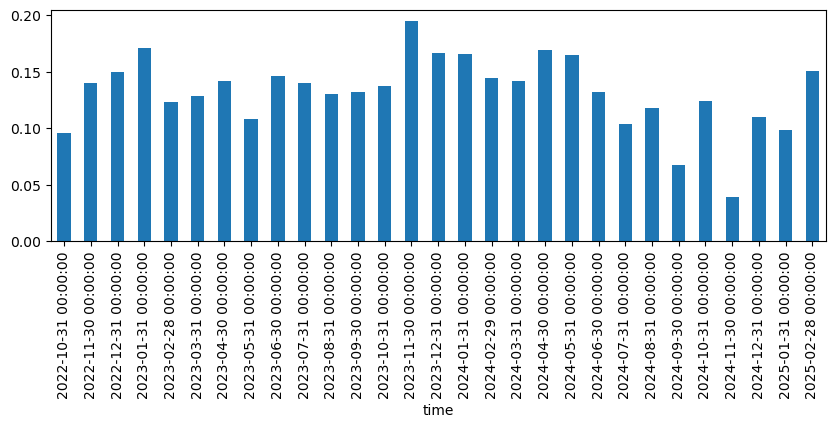

In [2130]:
mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            roc_auc_score(x['target'], x['y_pred'])
                                                                                                          ) - 0.5).plot.bar()

#### 2. WIN

In [2134]:
np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

0.2591240486482249

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/3266791285.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

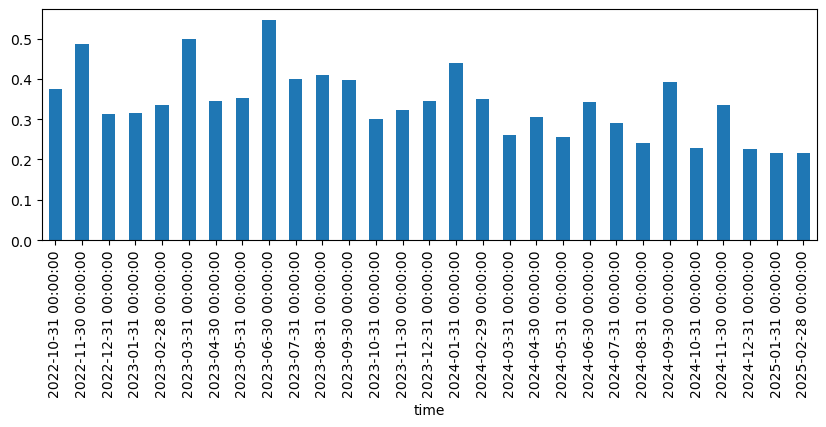

In [2137]:
q = 0.99
col_target = 'target'

mask_last_bin = df['y_pred'] >= np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()).plot.bar()

#### 3. income_rate

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/2651863704.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


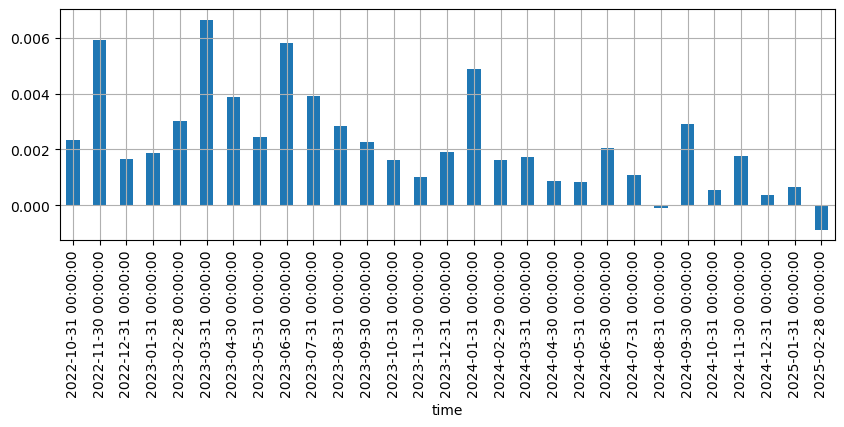

In [2141]:
q = 0.99
col_target = 'income_rate'

mask_last_bin = df['y_pred'] >= np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()) -1).plot.bar()
plt.grid()

#### 4. Отложенная выборка

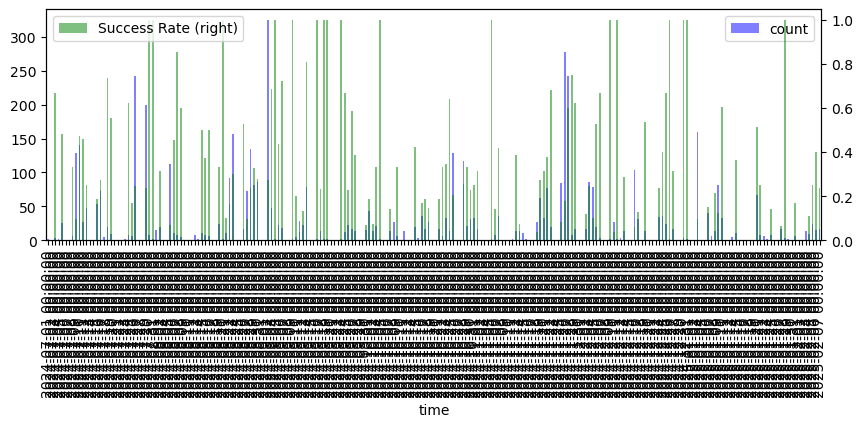

INCOME_RATE


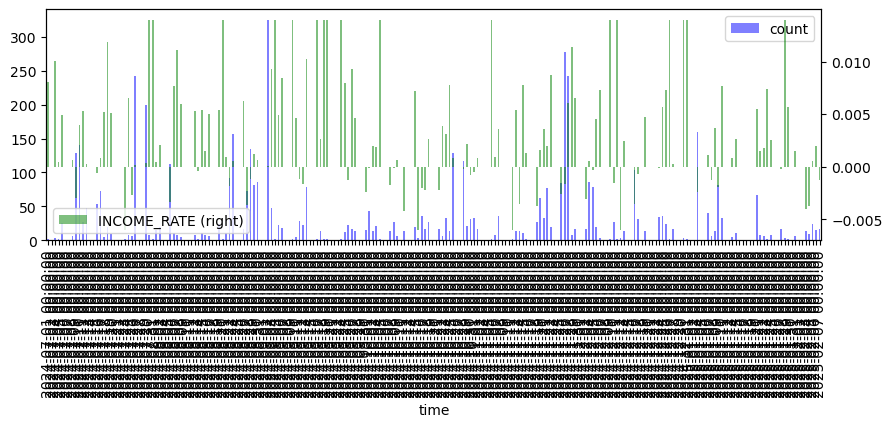

In [2148]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.99
freq='D'

mask_data = mask_valid|mask_test|mask_test2|mask_test3

threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] >= threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [2151]:
#y_test3

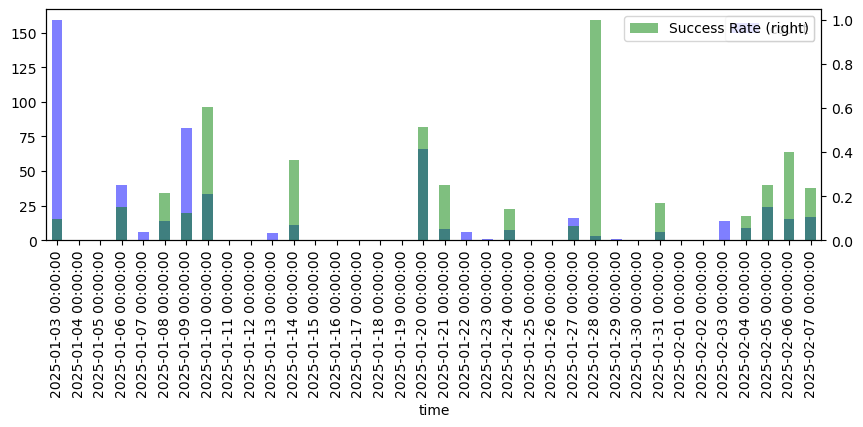

INCOME_RATE


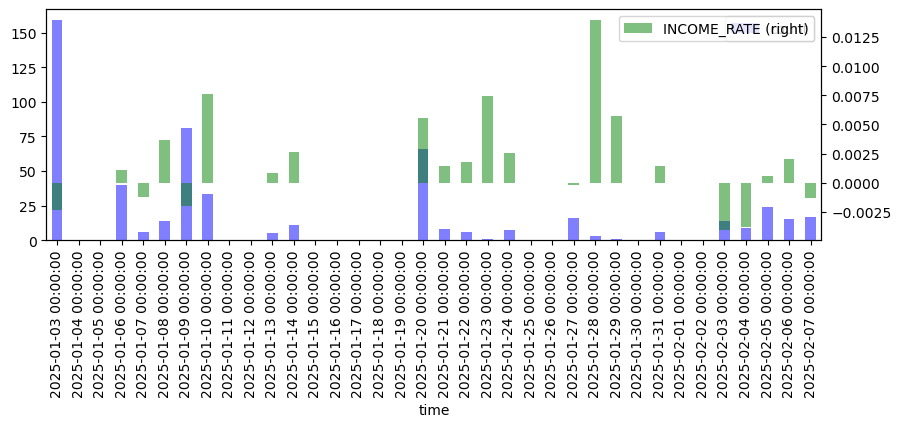

In [2153]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.99
freq='D'


mask_data = mask_test3


threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] >= threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [2156]:
#mean_income_rate_by_day
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()


(0.0033925232, 0.0039304667, 0.0036743742)

In [2158]:
df.loc[mask_valid&mask_last_bin, 'time'].dt.date.nunique(), df.loc[mask_test&mask_last_bin, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask_last_bin, 'time'].dt.date.nunique()


(42, 42, 39)

In [2160]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)

In [2162]:
#sum_income_rate
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.06965980877478917, 0.08253980102017522, 0.07331658277097483)

In [2165]:
#test3
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()

0.0019698576

In [2167]:
df.loc[mask_test3&mask_last_bin, 'time'].dt.date.nunique()

22

In [2169]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.035311521548363894

In [2173]:
mask_data = mask_valid | mask_test | mask_test2

In [2175]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()


/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/1640586492.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0008289348788377716

In [2178]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/1656526771.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0005175173282623291

In [2180]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/192763211.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0017659252598172142

In [2182]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/1559495362.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.00015524106147961738

In [2184]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/2683039865.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0013936947692524302

#### Points in life

In [2188]:
threshold

0.2591240486482249

In [2190]:
mask_dev = df['time'] > pd.Timestamp('2025-01-20')
df.loc[mask_dev, 'y_pred'] = model.predict(df.loc[mask_dev, features_fe]) #feratures_fe

#threshold = 0.5695387939626755
df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: (x['y_pred'] >= threshold).sum())

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_27664/1532415291.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(


time
2025-01-20    66
2025-01-21     8
2025-01-22     6
2025-01-23     1
2025-01-24     7
2025-01-25     0
2025-01-26     0
2025-01-27    16
2025-01-28     3
2025-01-29     1
2025-01-30     0
2025-01-31     6
2025-02-01     0
2025-02-02     0
2025-02-03    14
2025-02-04     9
2025-02-05    24
2025-02-06    15
2025-02-07    17
Freq: D, dtype: int64

### Обучить на всем

In [2198]:
#features_fe

In [2472]:
mask_data = mask_train | mask_valid | mask_test | mask_test2
#mask_data = (pd.Timestamp('2024-01-01') <= df['time']) &  (df['time'] < pd.Timestamp('2025-01-01'))
#print(mask_data.sum())
#mask_data = mask_valid | mask_test | mask_test2
#mask_data = mask_test2

D_data = lgbm.Dataset(df.loc[mask_data, features_fe], label=df.loc[mask_data, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_data.income_rate = df.loc[mask_data, 'income_rate'].values

D_data.time = df.loc[mask_data, 'time'].values

In [2475]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [2429]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'num_boost_round': 17}

In [2431]:
model.num_trees()

17

In [2433]:
del params['metric'], params['early_stopping']

KeyError: 'metric'

In [2435]:
params['num_boost_round'] = 17

In [2437]:
model = lgbm.train(params, train_set=D_data)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [2468]:
model.num_trees()

17

In [2466]:
dump_pkl(model, 'model_-0.5_+1.5_4hour.pkl')

In [2477]:
y_pred_data= model.predict(D_data.data)


df["y_pred"] = None
df.loc[mask_data, 'y_pred'] = y_pred_data

roc_auc_score(D_data.label, y_pred_data)

0.6437486059475304

In [2479]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.6092218820291359

In [2482]:
THRESHOLD = threshold
THRESHOLD

0.2591240486482249

In [2484]:
mean_income_rate_point(D_data, y_pred_data, threshold=THRESHOLD)

0.0022094249725341797

In [2486]:
mean_income_rate_day(D_data, y_pred_data, threshold=THRESHOLD)

0.003565999

In [2488]:
mean_income_rate_month(D_data, y_pred_data, threshold=THRESHOLD)

0.06537664798088372

In [2491]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=THRESHOLD)

0.0008516311645507812

In [2492]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=THRESHOLD)

0.0027811702

In [2493]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=THRESHOLD)

0.05438732811146312

In [2497]:
# +-

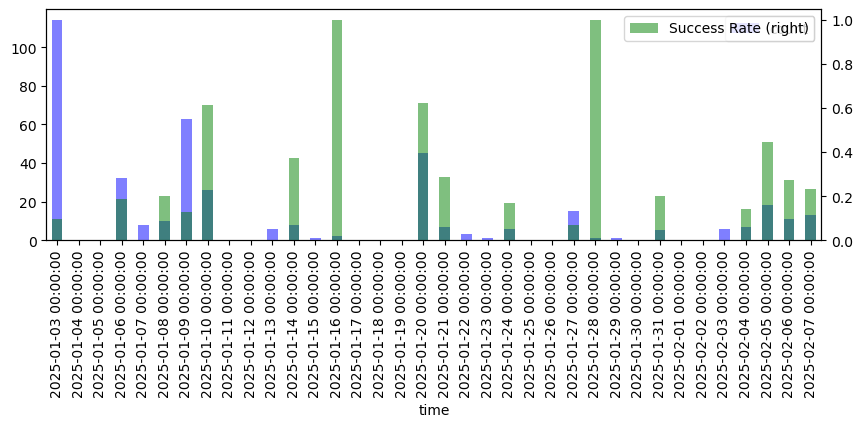

INCOME_RATE


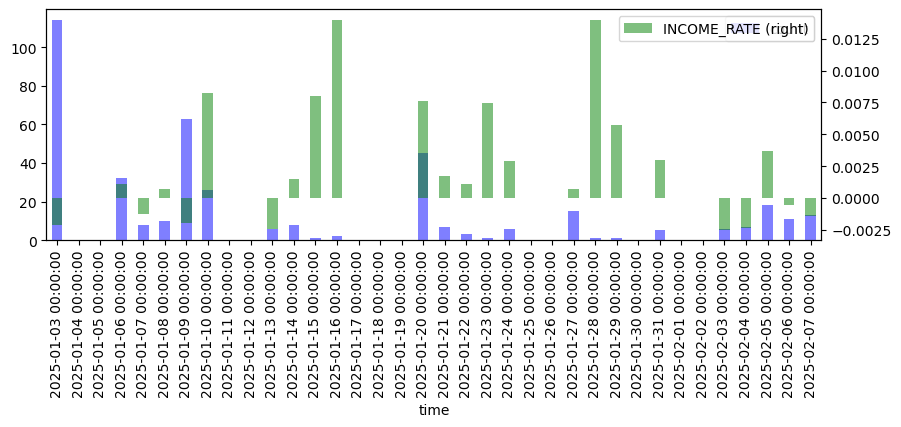

In [2499]:
#distibution in time
#win
col_pred = 'y_pred'
freq='D'


mask_data = mask_test3


#threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > THRESHOLD


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [3]:
import time
for i in range(100):
    print(i)
    time.sleep(1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
